# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 27.02.2023

Мягкий дедлайн: 18.03.2023 23:59 MSK

Жёсткий дедлайн: 25.03.2023 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/46988

Username — ваша фамилия и имя на латинице именно в таком порядке

Дефолтно засылал с неправильного акка, зовут NoMoreActimel.

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [14]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [16]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [15]:
from scipy.special import expit, logsumexp, softmax
from scipy.optimize import check_grad

In [49]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [50]:
def likelihood(alpha, beta):
    """ p(l=z|z, \alpha, \beta) for z_0, z_1
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
    """
    outer_product = np.outer(beta, alpha)
    return expit(outer_product), expit(-outer_product)
    

def log_likelihood(alpha, beta):
    """ log p(l=z|z, \alpha, \beta) for z_0, z_1
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
    """
    outer_product = np.outer(beta, alpha)
    return -softplus(-outer_product), -softplus(outer_product)

def log_posterior_sum_term(alpha, beta, L):
    """ Log-posterior - without p(z) term: log p(z|l, \alpha, \beta) - log p(z)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    log_sigmoid_pos, log_sigmoid_neg = log_likelihood(alpha, beta)

    zeros_hits = (L == 0)
    ones_hits = 1 - zeros_hits

    zeros_log_likelihood = np.sum(zeros_hits * log_sigmoid_pos + ones_hits * log_sigmoid_neg, axis=1)
    ones_log_likelihood = np.sum(ones_hits * log_sigmoid_pos + zeros_hits * log_sigmoid_neg, axis=1)

    return zeros_log_likelihood, ones_log_likelihood


def log_posterior(alpha, beta, L):
    """ Log-posterior: log p(z|l, \alpha, \beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    p_0 = 0.5
    p_1 = 1 - p_0

    zeros_log_likelihood, ones_log_likelihood = log_posterior_sum_term(alpha, beta, L)
    return np.log(p_0) + zeros_log_likelihood, np.log(p_1) + ones_log_likelihood


def posterior(alpha, beta, L):
    """ Posterior: p(z|l, \alpha, \beta), having shape (2, n_problems)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """

    q_log_zeros, q_log_ones = log_posterior(alpha, beta, L)
    q_zeros, q_ones = np.exp(q_log_zeros), np.exp(q_log_ones)
    prior = q_zeros + q_ones

    q = np.vstack([q_zeros / prior, q_ones / prior])
    
    assert q.shape == (2, L.shape[0]), q.shape
    return q


def grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha, wrt logbeta
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    log_sigmoid_pos, log_sigmoid_neg = likelihood(alpha, beta)

    zeros_hits = (L == 0)
    ones_hits = 1 - zeros_hits

    zeros_sum_term = zeros_hits * log_sigmoid_neg - ones_hits * log_sigmoid_pos
    ones_sum_term = ones_hits * log_sigmoid_neg - zeros_hits * log_sigmoid_pos

    grad_alpha = ((q[0, :] * beta) @ zeros_sum_term + (q[1, :] * beta) @ ones_sum_term).T
    grad_beta = (q[0, :].T * (zeros_sum_term @ alpha) + q[1, :].T * (ones_sum_term @ alpha)).T
    grad_logbeta = grad_beta * beta

    return grad_alpha, grad_logbeta


def lower_bound(alpha, beta, L, q):
    """ Lower bound
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    log_sigmoid_pos, log_sigmoid_neg = log_likelihood(alpha, beta)

    zeros_hits = (L == 0)
    ones_hits = 1 - zeros_hits

    log_likelihood_term = np.vstack([
        np.sum(zeros_hits * log_sigmoid_pos + ones_hits * log_sigmoid_neg, axis=1),
        np.sum(ones_hits * log_sigmoid_pos + zeros_hits * log_sigmoid_neg, axis=1)
    ])

    return np.sum(log_likelihood_term * q)

In [51]:
def em(L, n_steps=1000, lr=1e-3):
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5

    for step in range(n_steps):
        q = posterior(alpha=alpha, beta=np.exp(logbeta), L=L)
        # lb = lower_bound(alpha=alpha, beta=np.exp(logbeta), L=L, q=q)

        grad_alpha, grad_logbeta = grad_lb(alpha=alpha, beta=np.exp(logbeta), L=L, q=q)
        alpha, logbeta = alpha + lr * grad_alpha, logbeta + lr * grad_logbeta

    return alpha, np.exp(logbeta), q

In [52]:
alpha, beta, q = em(L, n_steps=1000, lr=1e-3)

In [53]:
lower_bound(alpha, beta, L, q)

-14687.331902516911

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$).

In [16]:
from sklearn.metrics import accuracy_score

In [55]:
y = np.load('y.npy')

voting_predicts = (np.sign(np.sum(L - 0.5, axis=1)) + 1) // 2
voting_accuracy = accuracy_score(voting_predicts, y)
print(f'Voting accuracy: {voting_accuracy}')

em_predicts = np.argmax(q, axis=0)
em_accuracy = accuracy_score(em_predicts, y)
if em_accuracy < 0.5:
    em_accuracy = accuracy_score(1 - em_predicts, y)
print(f'EM accuracy: {em_accuracy}')

Voting accuracy: 0.904
EM accuracy: 0.955


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли верно размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
expert_accuracies = [accuracy_score(L[:, i], y) for i in range(L.shape[1])]

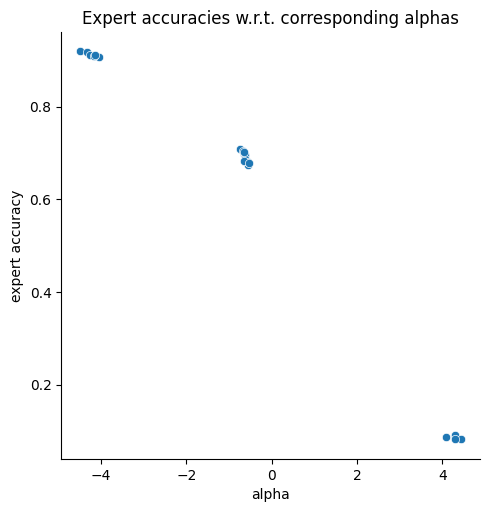

In [58]:
sns.relplot(y=expert_accuracies, x=alpha)
plt.xlabel('alpha')
plt.ylabel('expert accuracy')
plt.title('Expert accuracies w.r.t. corresponding alphas')
plt.show()

Реально есть челы, намеренно голосующие неправильно. Также есть группа ошибающихся экспертов, причём судя по кучности всех трёх групп, альфа - прям хорошо интерпретируемый параметр.

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [59]:
def em_with_known_answers(L, n_steps=1000, lr=1e-3, known_indices=None, known_labels=None):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    q = np.ones((2, len(logbeta))) * 0.5
    q[0, known_indices] = 1 - known_labels
    q[1, known_indices] = known_labels

    unknown_indices = np.delete(np.arange(L.shape[0]), known_indices)
    L_unknown = L[unknown_indices, :]

    for step in range(n_steps):
        beta_unknown = np.exp(logbeta)[unknown_indices]
        q[:, unknown_indices] = posterior(alpha=alpha, beta=beta_unknown, L=L_unknown)

        grad_alpha, grad_logbeta = grad_lb(alpha=alpha, beta=np.exp(logbeta), L=L, q=q)
        alpha, logbeta = alpha + lr * grad_alpha, logbeta + lr * grad_logbeta

    return alpha, np.exp(logbeta), q

In [60]:
voting_predicts = (np.sign(np.sum(L - 0.5, axis=1)) + 1) // 2
voting_accuracy = accuracy_score(voting_predicts, y)
print(f'Voting accuracy: {voting_accuracy}')

Voting accuracy: 0.904


In [64]:
known_counts = [0, 100, 200, 400, 800, 1600]

for known_count in known_counts:
    alpha, beta, q = em_with_known_answers(
        L, n_steps=1000, lr=1e-3,
        known_indices=np.arange(known_count), known_labels=y[:known_count]
    )
    em_predicts = np.argmax(q, axis=0)
    em_accuracy = accuracy_score(em_predicts, y)
    if em_accuracy < 0.5:
        em_accuracy = accuracy_score(1 - em_predicts, y)
        
    print(f'EM accuracy with {known_count} known answers: {em_accuracy}')

EM accuracy with 0 known answers: 0.956
EM accuracy with 100 known answers: 0.958
EM accuracy with 200 known answers: 0.86
EM accuracy with 400 known answers: 0.9645
EM accuracy with 800 known answers: 0.973
EM accuracy with 1600 known answers: 0.9915


# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [23]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

In [1]:
import glob
import os
from preprocessing import extract_sentences

all_sentences = []
all_targets = []

root_path = 'data/merged_data'

for dir_name in os.listdir(root_path):
    dir_path = root_path + '/' + dir_name
    for file_name in os.listdir(dir_path):
        file_path = dir_path + '/' + file_name
        sentences, targets = extract_sentences(file_path)
        all_sentences += sentences
        all_targets += targets

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [2]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [3]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [4]:
from metrics import compute_aer

compute_aer(all_targets, baseline.align(tokenized_sentences))

0.8074618330841489

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

(∩｀-´)⊃━☆ﾟ.*･｡ﾟ

Покоординатное правдоподобие латентных переменных:
$
p(a_i, T | S, \theta) = \theta(t_i | s_{a_i})
$

Так как $a_i$ не зависят друг от друга, посчитаем покоординатно $q^{*} (a_i)$:
$$
q^{*} (a_i) = p(a_i | T, S, \theta) = 
\frac{p(a_i, T | S, \theta)}{\sum_{c=1}^{n} p(c, T | S, \theta)} = 
\frac{\theta(t_i | s_{a_i})}{\sum_{c=1}^{n} \theta(t_i | s_c)}
$$

$$
q^{*} (A) = \frac
{\prod_{i=1}^{m} \theta(t_i | s_{a_i})}
{\prod_{i=1}^{m} \sum_{c=1}^{n} \theta(t_i | s_c)}
$$

Поначалу я долго втыкал в эти формулы, пытаясь найти лажу, почему же произведение и сумма поменялись местами, да ещё и в сумме не страшный перебор по всем возможным векторам.
Но потом был приятно удивлён, увидев то же самое в [конспекте второй лекции какого-то чела](https://www.cl.uni-heidelberg.de/courses/ss15/smt/scribe2.pdf).

Запишем оптимизационную задачу по каждому из $P$ предложений (до этого я опускал индексы предложения):
$$
\mathbf{E}_{p(A | T, S, \theta^{old})} \log p(A, T | S, \theta) = 
\mathbf{E}_{p(A | T, S, \theta^{old})} \left[ 
\sum_{p=1}^{P} \sum_{i=1}^{m} \log p(A_{i}^{(p)}, T^{(p)} | S^{(p)}, \theta) 
\right] = 
\mathbf{E}_{p(A | T, S, \theta^{old})} \left[ 
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} I \{A_{i}^{(p)} = j \} 
\log \frac{1}{n} \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) 
\right] =
$$
$$
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} p(A_{i}^{(p)} | T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot I \{A_{i}^{(p)} = j \} \cdot 
\log \frac{1}{n} \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) 
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
\log \frac{1}{n} \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) 
=
$$
$$
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
\frac{\theta^{old} (T_{i}^{(p)} | S_{j}^{(p)})}{\sum_{c=1}^{n} \theta^{old} (T_{i}^{(p)} | S_{c}^{(p)})}
\cdot \log \frac{1}{n} \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) 
$$

Здесь я опустил деление на логарифм апостериорного, для максимизации он нам не нужен. Но в подсчёте ELBO надо про него не забыть.

Перед тем как максимизировать это чудо, вспомним, что $\theta$ - матрица условных вероятностей, а значит суммы по колонкам равны 1. 

Введём дополнительно $V_T$ и $V_S$ - размеры словарей $T$ и $S$. Тогда $\theta$ размера $V_T \cdot V_S$ и $\forall v_S \in \{ 1 , ... , V_S \} : \: \sum_{v_T = 1}^{V_T} \theta(v_T, v_S) = 1$.

Кажется, пришло время для Лагранжианов:
$$
\mathcal{L} 
= 
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) \cdot
\log \frac{1}{n} \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) 
-
\sum_{v_S=1}^{V_S} \lambda_{v_S} \left( \sum_{v_T=1}^{V_T} \theta(v_T | v_S) - 1 \right) 
$$
$$
\frac{\partial \mathcal{L}}{\partial \theta} \, \bigg|_{v_T, v_S} 
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
I \{ T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S \} 
\cdot
\frac{1}{\theta(T_{i}^{(p)} | S_{j}^{(p)})} - \lambda_{v_S}
= 
\frac{matches(v_S, v_T)}{\theta(v_T | v_S)} - \lambda_{v_S} = 0 \; ,
$$
$$
matches(v_S, v_T) = \sum_{p=1}^{P} \sum_{i=1}^{m_p} \sum_{j=1}^{n_p}
p(A_{i}^{(p)} = j | T^{(p)}, S^{(p)}, \theta^{old})
\cdot
I \{ T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S \}
$$
$$
\text{Тогда:} \quad
\theta(v_T | v_S) = \frac{matches(v_S, v_T)}{\lambda_{v_S}}
\, , \;
\sum_{v_T = 1}^{V_T} \theta(v_T | v_S) = \sum_{v_T = 1}^{V_T} \frac{matches(v_S, v_T)}{\lambda_{v_S}} = 1
\; \Rightarrow \;
\theta(v_T | v_S) = \frac{matches(v_S, v_T)}{\sum_{v_{T}^{'} = 1}^{V_T} matches(v_S, v_{T}^{'})}
$$

Этот вывод по идее аналогичен упомянотому в второй лекции выводу из [первой](https://www.cl.uni-heidelberg.de/courses/ss15/smt/scribe1.pdf). В целом $matches$ - это апостериорное распределение, посчитанное только для инексов $(i, j): \; T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S$.

Осталось ELBO:
$$
ELBO =
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
\log \left( \frac{\theta(T_{i}^{(p)} | S_{j}^{(p)})}
{n \, p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old})}
\right)
$$

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

In [71]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
history = word_aligner.fit(tokenized_sentences);

# ༼つ ಠ益ಠ༽つ ─=≡ΣO))
aligned = word_aligner.align(tokenized_sentences)
compute_aer(all_targets, aligned)

0.574871620717689

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [6]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [8]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [9]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [10]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [11]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['dne', 'jež', 'S']

In [12]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [44]:
# x from source, y from target
# p(x | y) = p(x, y) / p(y) = p(y | x) * p(x) / p(y)

import typing as tp
from collections import Counter


def get_word_probs(corpus: tp.Iterator[list], vocab_size):
    counter = Counter()
    
    for sentence in corpus:
        counter.update(sentence)
    
    prior = np.zeros(vocab_size)
    prior[list(counter.keys())] = np.array(list(counter.values())) / counter.total()
    
    return prior


source_probs = get_word_probs((sentence.source_tokens for sentence in tokenized_sentences), len(t_idx_src))
target_probs = get_word_probs((sentence.target_tokens for sentence in tokenized_sentences), len(t_idx_tgt))

source_to_target_probs = word_aligner.translation_probs
target_to_source_probs = source_to_target_probs * source_probs[:, np.newaxis] / target_probs

In [72]:
idx_token_src = {index: token for token, index in t_idx_src.items()}

In [93]:
def translate_from_target(target_token):
    source_index = target_to_source_probs[:, t_idx_tgt[target_token]].argmax()
    return idx_token_src[source_index]

In [94]:
translate_from_target('vody')

'water'

In [95]:
translate_from_target('mezinárodní')

'international'

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

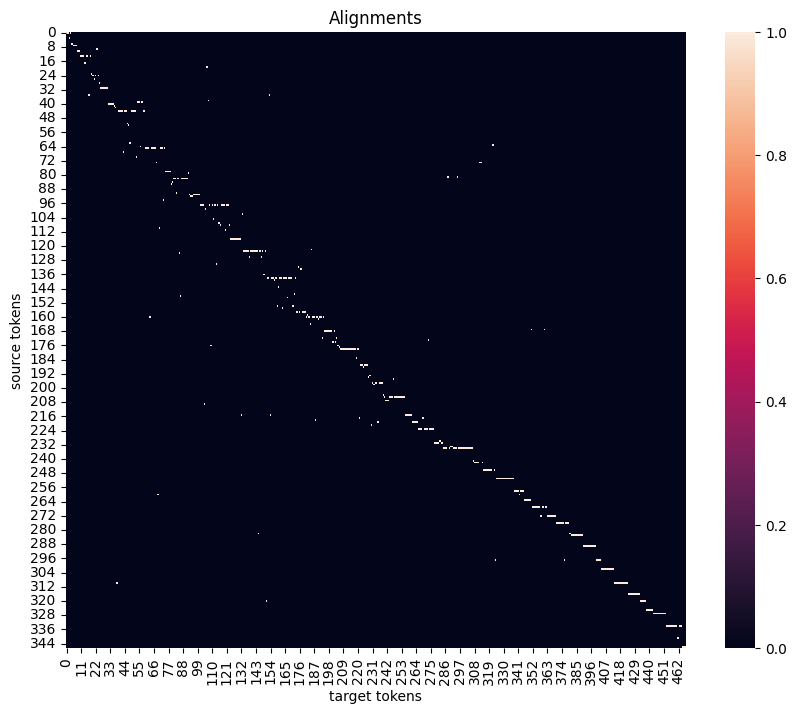

In [36]:
hits = np.zeros_like(word_aligner.translation_probs)
hits[np.argmax(word_aligner.translation_probs, axis=0), np.arange(len(t_idx_tgt))] = 1

plt.figure(figsize=(10, 8))
sns.heatmap(hits)
plt.title('Alignments')
plt.ylabel('source tokens')
plt.xlabel('target tokens')
plt.show()

Модель выбирает подходящие токены исходного языка ступеньками, то есть очень часто для соседних по индексу таргетов выбирается один и тот же сорс. 

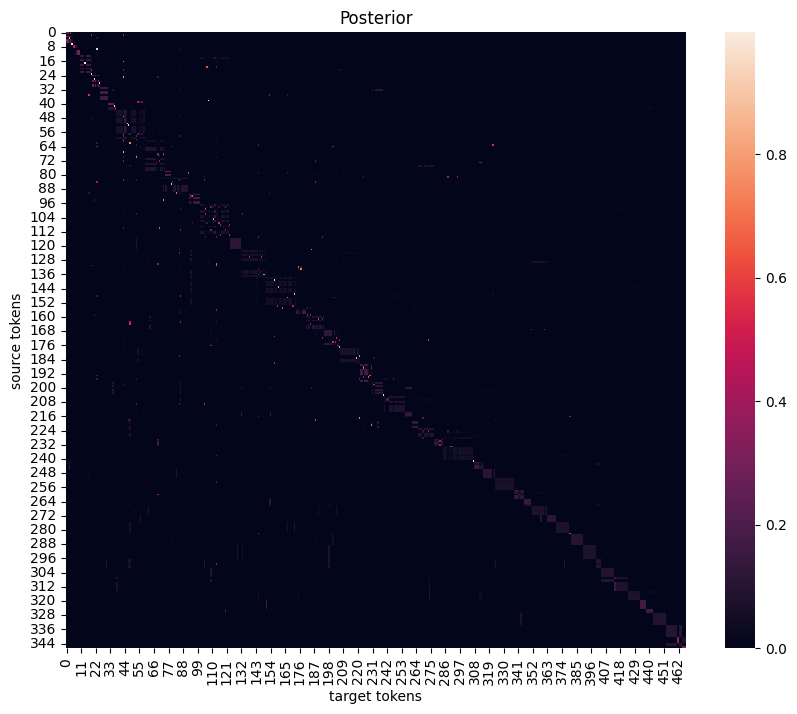

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(word_aligner.translation_probs)
plt.title('Posterior')
plt.ylabel('source tokens')
plt.xlabel('target tokens')
plt.show()

По апостериорному распределению видно, что один исходный токен на много целевых выбирается в "неуверенных прямоугольниках", которых больше в больших индексах - логично, ведь большие индексы получали редкие слова, не встреченные до этого в текстах. Зачастую мы их видели всего пару раз, тогда лучшая попытка перевода - гадание на соседях.

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

(∩｀-´)⊃━☆ﾟ.*･｡ﾟ
$$
q^{*} (a_i) = p(a_i | T, S, \theta) = 
\frac{p(a_i, T | S, \theta)}{\sum_{c=1}^{n} p(c, T | S, \theta)} = 
\frac{\phi_{m, n} (a_i | i) \,\theta(t_i | s_{a_i})}
{\sum_{c=1}^{n} \phi_{m, n} (c | i) \, \theta(t_i | s_c)}
$$

$$
q^{*} (A) = \frac
{\prod_{i=1}^{m} \phi_{m, n} (a_i | i) \, \theta(t_i | s_{a_i})}
{\prod_{i=1}^{m} \sum_{c=1}^{n} \phi_{m, n} (c | i) \, \theta(t_i | s_c)}
$$

Запишем оптимизационную задачу по каждому из $P$ предложений (до этого я опускал индексы предложения):
$$
\mathbf{E}_{p(A | T, S, \theta^{old})} \log p(A, T | S, \theta) = 
\mathbf{E}_{p(A | T, S, \theta^{old})} \left[ 
\sum_{p=1}^{P} \sum_{i=1}^{m} \log p(A_{i}^{(p)}, T^{(p)} | S^{(p)}, \theta) 
\right] = 
$$
$$
=
\mathbf{E}_{p(A | T, S, \theta^{old})} \left[ 
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} I \{A_{i}^{(p)} = j \} 
\log \left( \phi_{m, n} (j | i) \cdot \theta(T_{i}^{(p)} | S_{j}^{(p)}) \right)
\right] =
$$
$$
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} p(A_{i}^{(p)} | T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot I \{A_{i}^{(p)} = j \} \cdot 
\log \left( \phi_{m, n} (j | i) \cdot \theta(T_{i}^{(p)} | S_{j}^{(p)}) \right)
=
$$
$$
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
\log \left( \phi_{m, n} (j | i) \cdot \theta(T_{i}^{(p)} | S_{j}^{(p)}) \right)
=
$$
$$
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
\frac{\phi_{m, n}^{old} (j | i) \, \theta^{old} (T_{i}^{(p)} | S_{j}^{(p)})}
{\sum_{c=1}^{n} \phi_{m, n}^{old} (c | i) \,\theta^{old} (T_{i}^{(p)} | S_{c}^{(p)})}
\cdot \log \left( \phi_{m, n} (j | i) \cdot \theta(T_{i}^{(p)} | S_{j}^{(p)}) \right)
$$

Здесь я опустил деление на логарифм апостериорного, для максимизации он нам не нужен. Но в подсчёте ELBO надо про него не забыть.

Перед тем как максимизировать это чудо, вспомним, что $\theta$ - матрица условных вероятностей, а значит суммы по колонкам равны 1. 

Введём дополнительно $V_T$ и $V_S$ - размеры словарей $T$ и $S$. Тогда $\theta$ размера $V_T \cdot V_S$ и $\forall v_S \in \{ 1 , ... , V_S \} : \: \sum_{v_T = 1}^{V_T} \theta(v_T, v_S) = 1$.

Кажется, пришло время для Лагранжианов:
$$
\mathcal{L} 
= 
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) \cdot
\log \left( \phi_{m, n} (j | i) \, \theta(T_{i}^{(p)} | S_{j}^{(p)}) \right)
-
\sum_{v_S=1}^{V_S} \lambda_{v_S}^{\theta} \left( \sum_{v_T=1}^{V_T} \theta(v_T | v_S) - 1 \right) 
-
\sum_{m_0, n_0} \sum_{i=1}^{n_0} \lambda_{m_0, n_0, i}^{\phi} \left( \sum_{j=1}^{m_0} (\phi(j | i) - 1 \right) 
$$
$$
\frac{\partial \mathcal{L}}{\partial \theta} \, \bigg|_{v_T, v_S} 
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
I \{ T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S \} 
\cdot
\frac{1}{\theta(T_{i}^{(p)} | S_{j}^{(p)})} - \lambda_{v_S}^{\theta}
= 
\frac{matches (v_S, v_T)}{\theta(v_T | v_S)} - \lambda_{v_S}^{\theta} = 0 \; ,
$$
$$
matches (v_S, v_T) = \sum_{p=1}^{P} \sum_{i=1}^{m_p} \sum_{j=1}^{n_p}
p(A_{i}^{(p)} = j | T^{(p)}, S^{(p)}, \theta^{old})
\cdot
I \{ T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S \}
$$
$$
\text{Тогда:} \quad
\theta(v_T | v_S) = \frac{matches (v_S, v_T)}{\lambda_{v_S}^{\theta}}
\, , \;
\sum_{v_T = 1}^{V_T} \theta(v_T | v_S) = 
\sum_{v_T = 1}^{V_T} \frac{matches (v_S, v_T)}{\lambda_{v_S}^{\theta}} = 1
\; \Rightarrow \;
$$
$$
\theta(v_T | v_S) = \frac{matches (v_S, v_T)}{\sum_{v_{T}^{'} = 1}^{V_T} matches (v_S, v_{T}^{'})}
$$

$$
\frac{\partial \mathcal{L}}{\partial \phi_{m_0, n_0}} \, \bigg|_{j_0, i_0} 
=
\sum_{p=1}^{P} \sum_{i=1}^{m} \sum_{j=1}^{n} 
p(A_{i}^{(p)} = j| T^{(p)}, S^{(p)}, \theta^{old}) 
\cdot
\frac{I \{ m = m_0, n = n_0, j = j_0, i = i_0 \}}{\phi_{m_0, n_0} (j_0 | i_0)} 
- \lambda_{m_0, n_0, i_0}^{\phi}
= 
\frac{matches_{n_0, m_0} (i_0, j_0)}{\phi_{m_0, n_0} (j_0 | i_0)} - \lambda_{m_0, n_0, i_0}^{\phi} = 0 \; ,
$$
$$
matches_{n_0, m_0} (i_0, j_0) = \sum_{p=1}^{P} \sum_{i=1}^{m_p} \sum_{j=1}^{n_p}
p(A_{i}^{(p)} = j | T^{(p)}, S^{(p)}, \theta^{old})
\cdot
I \{ m = m_0, n = n_0, j = j_0, i = i_0 \}
$$
$$
\text{Тогда:} \quad
\phi_{m_0, n_0} (j_0 | i_0) = \frac{matches_{n_0, m_0} (i_0, j_0)}{\lambda_{m_0, n_0, i_0}^{\phi}}
\, , \;
\sum_{j = 1}^{n_0} \phi_{m_0, n_0} (j | i_0) = 
\sum_{j = 1}^{n_0} \frac{matches_{n_0, m_0} (i_0, j)}{\lambda_{m_0, n_0, i_0}^{\phi}} = 1
\; \Rightarrow \;
$$
$$
\phi_{m_0, n_0} (j_0 | i_0) = 
\frac{matches_{n_0, m_0} (i_0, j_0)}{\sum_{j = 1}^{n_0} matches_{n_0, m_0} (i_0, j)}
$$

Этот вывод по идее аналогичен упомянотому в второй лекции выводу из [первой](https://www.cl.uni-heidelberg.de/courses/ss15/smt/scribe1.pdf). $matches$ - это апостериорное распределение, посчитанное только для инексов $(i, j): \; T_{i}^{(p)} = v_T, S_{j}^{(p)} = v_S$, а $matches_{m_0, n_0}$ - тоже апостериорное, но только для пар предложений длин $m_0, n_0$.


**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

In [68]:
from models import WordPositionAligner

word_pos_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
history = word_pos_aligner.fit(tokenized_sentences);

aligned = word_pos_aligner.align(tokenized_sentences)
compute_aer(all_targets, aligned)

# ༼つ ಠ益ಠ༽つ ─=≡ΣO))

0.5803978471386084

In [70]:
word_pos_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_pos_aligner.translation_probs = word_aligner.translation_probs
history = word_pos_aligner.fit(tokenized_sentences);

aligned = word_pos_aligner.align(tokenized_sentences)
compute_aer(all_targets, aligned)

# (੭•̀ω•́)੭̸*✩⁺˚

0.5778559888034742

Качество немного просело... Но инициализация всё же исправляет дело.

**Задание 7. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ